In [4]:
pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from __future__ import unicode_literals
#from hazm import *
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

## Input datasets
I read from 5 datasets and combine them toghether

because of the datasets fault, I can't separate them in file reading time, so I read it as a 1 column

In [3]:
csv1 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part1.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv2 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part2.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv3 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part3.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv4 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part4.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
#csv5 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part5.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)     #changable

In [4]:
mainCsv = pd.DataFrame(columns=['All'])
mainCsv = mainCsv.append(csv1, ignore_index=True)
mainCsv = mainCsv.append(csv2, ignore_index=True)
mainCsv = mainCsv.append(csv3, ignore_index=True)
mainCsv = mainCsv.append(csv4, ignore_index=True)
#data = data.append(csv5, ignore_index=True)   #changeable
mainCsv

,All
0,ویکی‌پدیای\tO
1,انگلیسی\tO
2,در\tB-DAT
3,تاریخ\tI-DAT
4,۱۵\tI-DAT
...,...
10527407,روی\tO
10527408,میز\tO
10527409,گزارشگران\tO
10527410,کوبیدند\tO


In [5]:
tmp = mainCsv['All'].str.rsplit("\t", 1)
dataWord = pd.DataFrame(list(tmp), columns = ['Token', 'NameEntity'])
dataWord

,Token,NameEntity
0,ویکی‌پدیای,O
1,انگلیسی,O
2,در,B-DAT
3,تاریخ,I-DAT
4,۱۵,I-DAT
...,...,...
10527407,روی,O
10527408,میز,O
10527409,گزارشگران,O
10527410,کوبیدند,O


(-1.1022759568793803,
 1.1156535267577499,
 -1.101051752794597,
 1.1000500951049306)

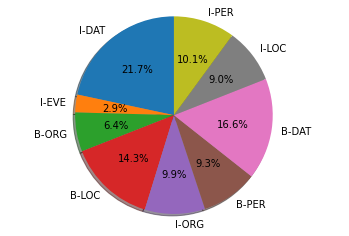

In [6]:
x = dataWord['NameEntity'].value_counts()[1:-1]
x = shuffle(x)
fig1, ax1 = plt.subplots()
ax1.pie(x.values, labels=x.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

In [7]:
dataWord['NameEntity'].value_counts()

O        8728635
I-DAT     383590
B-DAT     294479
B-LOC     252790
I-PER     178051
I-ORG     174526
B-PER     164234
I-LOC     158827
B-ORG     113397
I-EVE      51561
B-EVE      27310
Name: NameEntity, dtype: int64

In [8]:
nanIndices = dataWord['NameEntity'][dataWord['NameEntity'].isnull().values].index
nanIndices

Int64Index([ 1193638,  2569124,  2613297,  5508457,  7587616,  8104097,
             8265958,  8566774,  8709133,  8753008,  8968246, 10258056],
           dtype='int64')

In [9]:
dataWord.iloc[nanIndices]

,Token,NameEntity
1193638,http://turnbull.mcs.st-and.ac.uk/,None
2569124,http://kiau.ac.ir/,None
2613297,2,None
5508457,http://sharif.edu/,None
7587616,members.tripod.com/,None
8104097,http://www.rph.wa.gov.au/,None
8265958,http://sharif.edu/,None
8566774,http://web.eecs.umich.edu/,None
8709133,http://lisa.cs.duke.edu/,None
8753008,http://freepages.genealogy.rootsweb.ancestry.com/,None


In [10]:
dataWord = dataWord.dropna()
dataWord = dataWord.reset_index(drop = True)

In [11]:
dataWord.iloc[nanIndices]

,Token,NameEntity
1193638,در,O
2569124,کشور,B-LOC
2613297,ایران,B-LOC
5508457,رساله,O
7587616,زازاکی,O
8104097,وایلی,O
8265958,فرزند,O
8566774,مشورتی,O
8709133,هنوز,O
8753008,.,O


In [12]:
def makeSentences(dotIndices, data):
  columns = ['Text', 'Label']
  df= []
  begin = 0
  for i in range(len(dotIndices)):
    tmp = data.iloc[begin:dotIndices[i]]
    begin = dotIndices[i] + 1
    _list=[]
    _list.append(' '.join(list(tmp['Token'])))
    _list.append(' '.join(list(tmp['NameEntity'])))
    df.append(_list)
  df= pd.DataFrame(df,columns=list(columns))
  return df

In [13]:
def label_to_one_hot(value):
  list_classes = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
  if value == list_classes[0]:
    return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[1]:
    return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[2]:
    return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[3]:
    return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[4]:
    return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  if value == list_classes[5]:
    return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  if value == list_classes[6]:
    return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  if value == list_classes[7]:
    return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  if value == list_classes[8]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  if value == list_classes[9]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  if value == list_classes[10]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [14]:
def removeBadSentences(X, Y):
  newX = []
  newY = []
  indices = []
  ind = -1

  for x, y in zip(X, Y):
    ind += 1
    if len(x) == len(y):
      indices.append(ind)
      newX.append(x)
      newY.append(y)

  return newX, newY, indices

In [15]:
def badPercentage(x, y):
  ind = -1
  notEquallen = 0

  for a,b in zip(x, y):
    ind += 1
    if len(a) != len(b):
      notEquallen += 1

  return notEquallen / len(list_tokenized_train)

In [16]:
dotIndices = list(dataWord['Token'][dataWord['Token'] == '.'].index)
dataSentences = makeSentences(dotIndices, dataWord)

In [17]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ ( م...,O O B-DAT I-DAT I-DAT I-DAT I-DAT O B-DAT O B-...
1,بنیان‌گذاران آن ، جیمی ولز و لری سنگر هستند,O O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
400326,۲۰۱۳ ) درگذشت و آندرتیکر و کین برای او مراسم ی...,O O O O B-ORG I-ORG I-ORG O O O O O
400327,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
400328,در سال بعد ( ۲۰۱۳ ) کمی قبل از رستلمنیا ۲۹ پول...,B-DAT B-DAT I-DAT O O O O O O B-EVE I-EVE O O ...
400329,در رستلمنیا ۲۹ یک مسابقه بین آندرتیکر و CM پان...,O B-EVE I-EVE O O O O O O O O O O O O O O O O ...


## Split data into X and y

In [18]:
yLabel = dataSentences['Label']
sentences = dataSentences['Text']

## Tokenization

In [24]:
max_features = 250015   # changeable
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences))
list_tokenized_train = tokenizer.texts_to_sequences(sentences)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in yLabel]

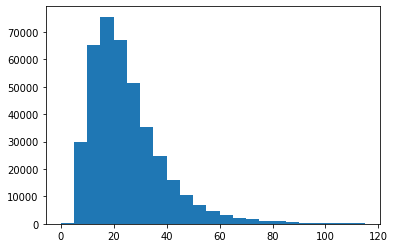

In [25]:
senLens = [len(sen) for sen in list_tokenized_train]
plt.hist(senLens, bins = np.arange(0,120,5))
plt.show()

## Find bad Sentences and remove them 

In [26]:
badPercentage(list_tokenized_train, y)

0.24964591800285263

In [27]:
list_tokenized_train, y, goodIndices = removeBadSentences(list_tokenized_train, y)

In [28]:
badPercentage(list_tokenized_train, y)

0.0

In [29]:
dataWord = dataWord.iloc[goodIndices]              #play once...
dataSentenses = dataSentences.iloc[goodIndices]

## Embedding

In [8]:
def loadEmbeddingMatrix(typeToLoad):
    if(typeToLoad=="fasttext"):
        EMBEDDING_FILE='/content/drive/MyDrive/NerDatas/cc.fa.300.vec'
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)
    else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            #print('Loaded %s word vectors.' % len(embeddings_index))
                        
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

In [9]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

total embedded: 227685 common words


In [19]:
a = np.load('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv.npy')

In [ ]:
dotIndices = list(data1['Token'][data1['Token'] == '.'].index)

In [ ]:
type(dotIndices)

list

In [ ]:
def makeSentences(dotIndices, data):
  columns = ['Text', 'Label']
  df= []
  begin = 0
  for i in range(len(dotIndices)-100):
    tmp = data.iloc[begin:dotIndices[i]]
    begin = dotIndices[i] + 1
    _list=[]
    _list.append(' '.join(list(tmp['Token'])))
    _list.append(' '.join(list(tmp['NameEntity'])))
    df.append(_list)
  df= pd.DataFrame(df,columns=list(columns))
  return df

In [ ]:
makeSentences(dotIndices, data1)

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ ( م...,O O B-DAT I-DAT I-DAT I-DAT I-DAT O B-DAT O B-...
1,بنیان‌گذاران آن ، جیمی ولز و لری سنگر هستند,O O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
98721,روز یکشنبه ۲۵ دی‌ماه ۱۳۹۰ ماموران امنیتی او را...,B-DAT I-DAT I-DAT O O O O O O O O O B-LOC O O ...
98722,او در تاریخ ۷ اسفند ۱۳۹۰ به قید وثیقه آزاد شد,O B-DAT I-DAT I-DAT I-DAT I-DAT O O O O O
98723,هنریک یوهان ایبسن ( زاده ۲۰ مارس ۱۸۲۸ در شین (...,O O O O O B-DAT I-DAT I-DAT O O O O O B-LOC B-...
98724,او یکی از بزرگ‌ترین استادان هنر تئاتر در تمامی...,O O O O O O O O O O O O O O B-PER O O


In [ ]:
data1.iloc[[1193638]]

,Token,NameEntity
1193638,در,O


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz

--2022-08-01 08:47:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258183862 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fa.300.vec.gz’

cc.fa.300.vec.gz    100%[===================>]   1.17G  24.4MB/s    in 47s     

2022-08-01 08:48:43 (25.4 MB/s) - ‘cc.fa.300.vec.gz’ saved [1258183862/1258183862]



In [ ]:
!gunzip cc.fa.300.vec.gz

In [ ]:
!mv cc.fa.300.vec /content/drive/MyDrive/NerDatas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive  sample_data


drive/  sample_data/


In [ ]:
normalizer = Normalizer()
normalizer.normalize('اصلاح نويسه ها و استفاده از نیم‌فاصله پردازش را آسان مي كند')

'اصلاح نویسه\u200cها و استفاده از نیم\u200cفاصله پردازش را آسان می\u200cکند'

In [ ]:
print(sentences[3])
normalizer.normalize(sentences[3])

کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند


'کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند'

In [ ]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()

In [ ]:
lemmatizer.lemmatize('می‌روم')

'رفت#رو'

In [ ]:
lemmatizer.lemmatize(sentences[3])

'کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند'

In [ ]:
list_tokenized_train[1]

[7412, 21, 8, 4758, 2951, 4, 5334, 8250, 113]

In [ ]:
sentences[1]

'بنیان\u200cگذاران آن ، جیمی ولز و لری سنگر هستند'

In [ ]:
a = dataWord['Token'][dataWord['Token'] == 'رویزیونیسم'].index

In [ ]:
dataWord.iloc[a[1] : a[1] + 19]

,Token,NameEntity
683244,رویزیونیسم,O
683245,می‌خوانند,O
683246,.,O
683247,استالین,O
683248,در,O
683249,۱۹۲۸,O
683250,سیاست,O
683251,نپ,O
683252,"( , ،",O
683253,سیاست,O


In [ ]:
a = -1
for i in dotIndices:
  a += 1
  if i == 683246:
    print(a)

25777


In [ ]:
dotIndices[25777]

683246

In [ ]:
sentences[25778].split()

In [25]:
ind = -1
notEquallen = 0
badSentenceIndices = []
for a,b in zip(list_tokenized_train, y):
  ind += 1
  if len(a) != len(b):
    badSentenceIndices.append(ind)
    notEquallen += 1
notEquallen / len(list_tokenized_train)

99941

In [26]:
notEquallen / len(list_tokenized_train)

0.24964591800285263

list

In [ ]:
len(list_tokenized_train[25778])

24

In [ ]:
len(y[25778])

25

In [28]:
badSentenceIndices

[0,
 6,
 8,
 11,
 12,
 16,
 20,
 21,
 24,
 25,
 26,
 27,
 29,
 30,
 32,
 33,
 34,
 58,
 59,
 61,
 62,
 70,
 71,
 72,
 74,
 75,
 77,
 83,
 84,
 86,
 87,
 88,
 89,
 91,
 92,
 97,
 104,
 109,
 120,
 122,
 130,
 137,
 144,
 148,
 150,
 155,
 157,
 158,
 159,
 163,
 178,
 189,
 191,
 195,
 203,
 206,
 215,
 217,
 219,
 220,
 223,
 242,
 244,
 247,
 249,
 251,
 253,
 254,
 257,
 260,
 263,
 264,
 267,
 270,
 281,
 283,
 289,
 301,
 305,
 317,
 318,
 337,
 349,
 352,
 353,
 355,
 357,
 366,
 368,
 370,
 376,
 377,
 381,
 388,
 389,
 390,
 393,
 403,
 404,
 410,
 424,
 441,
 443,
 444,
 446,
 452,
 453,
 454,
 456,
 458,
 459,
 460,
 463,
 465,
 475,
 479,
 482,
 484,
 494,
 495,
 502,
 507,
 511,
 514,
 517,
 519,
 526,
 529,
 530,
 533,
 536,
 539,
 542,
 543,
 544,
 545,
 546,
 548,
 549,
 551,
 555,
 556,
 557,
 558,
 560,
 566,
 568,
 570,
 572,
 575,
 576,
 577,
 580,
 585,
 589,
 593,
 598,
 599,
 604,
 608,
 612,
 634,
 635,
 640,
 643,
 649,
 651,
 654,
 656,
 663,
 665,
 666,
 672,
 